## Importing libraries

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from collections import Counter
import keras_tuner
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

## Preparing the training dataset

In [2]:
ds_path = r"C:\Users\badullah\Downloads\Jupyter Notebook\ct\train"

classes = {"normal": 0, "benign": 1, "malignant": 2} 

In [3]:
# Get list of all image file names 

ds_images = [] 

for key in classes.keys(): 

    folder = os.path.join(ds_path, key) 

    images = os.listdir(folder) 

    for img in images: 

        ds_images.append(os.path.join(folder, img)) 

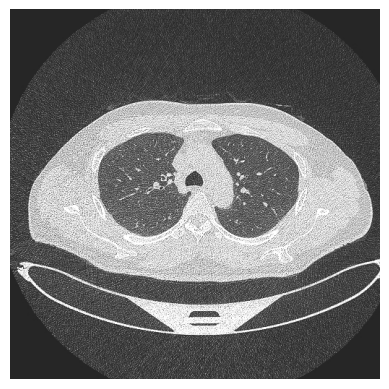

In [4]:
# Printing a random image from the dataset
random_image_path = random.choice(ds_images)
random_image = mpimg.imread(random_image_path)

plt.imshow(random_image)
plt.axis('off')  # Remove axis labels
plt.show()

In [5]:
# Create empty arrays for data and labels 

data = [] 

label = [] 

In [6]:
# Loop over all image file names, read images, preprocess them and store in data array 

for img in ds_images: 

    image = cv2.imread(img) 

    # Resize image to desired size
    
    image = cv2.resize(image, (224, 224))  

    # Normalize pixel values
    
    image = image.astype("float32") / 255.0 
    
    # convert the image to grayscale

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # append the image to the array

    data.append(image) 
    
    # Get corresponding label for image from folder name 

    labels = img.split(os.path.sep)[-2] 

    labels = classes[labels] 

    label.append(labels)

In [7]:
# Convert data and labels to numpy arrays 

X = np.array(data) 

y = np.array(label)

## Displaying the dataset

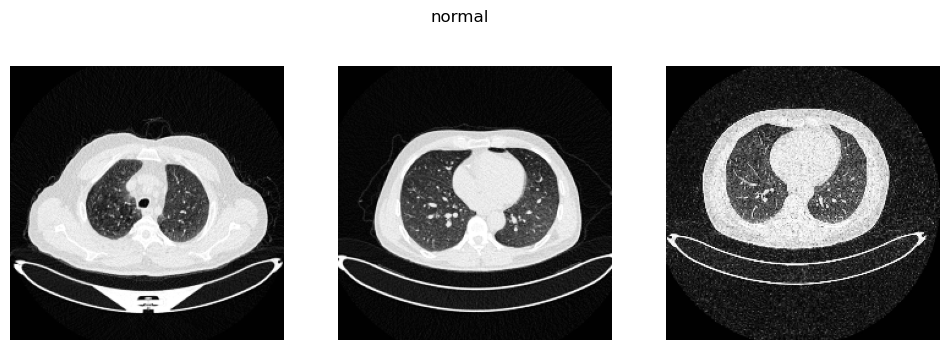

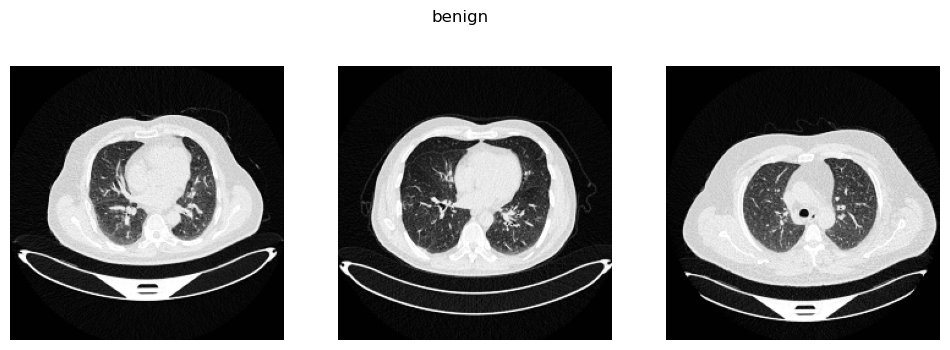

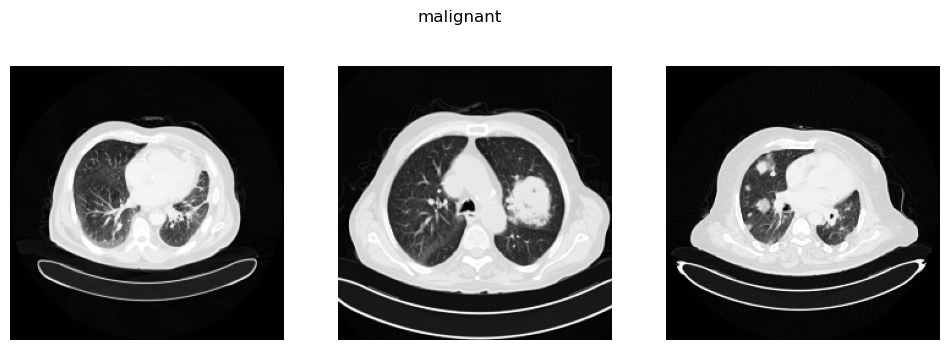

In [8]:
# Define the categories
categories = ['normal', 'benign', 'malignant']

# Create a dictionary to store images for each category
images_per_category = {category: [] for category in categories}

# Group the images based on their categories
for image, label in zip(X, y):
    images_per_category[categories[label]].append(image)

# Define the number of images to display for each category
num_images_per_category = 3

# Display the images
for category in classes:
    images = images_per_category[category][:num_images_per_category]
    
    # Create subplots to display multiple images in a grid
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    fig.suptitle(category)
    
    # Iterate over the images and display them
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='Greys_r')
        axes[i].axis('off')
    
    plt.show()


## Divide the dataset into training and testing parts

In [9]:
# split the data into training and testing sets with 40% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


## Checking infos about training and testing data

In [10]:
# print the shape of the train data

print(X_train.shape)
print(y_train.shape)
print(Counter(y_train))
print(X_train.dtype)

(658, 224, 224)
(658,)
Counter({2: 346, 0: 249, 1: 63})
float32


In [11]:
# print the shape of the test data

print(X_test.shape)
print(y_test.shape)
print(Counter(y_test))
print(X_test.dtype)

(439, 224, 224)
(439,)
Counter({2: 215, 0: 167, 1: 57})
float32


## CNN modelling

## Model 1

In [12]:
model1 = keras.Sequential([
    
    # Add hidden layers
    keras.layers.Conv2D(16, 3, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    
    # Add a flatten layer to enable transition from the conv layer
    keras.layers.Flatten(),
    
    # Add a fully connected layer
    keras.layers.Dense(128, activation='relu'),
    
    # Add dropout layer to prevent over-fitting
    keras.layers.Dropout(0.5),
    
    # Add an output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Train the model
history1 = model1.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
21/21 [==============================] - 19s 855ms/step - loss: 8.6243 - accuracy: 0.5076 - val_loss: 1.3034 - val_accuracy: 0.6834
Epoch 2/5
21/21 [==============================] - 18s 867ms/step - loss: 0.8509 - accuracy: 0.6596 - val_loss: 0.5994 - val_accuracy: 0.7654
Epoch 3/5
21/21 [==============================] - 17s 805ms/step - loss: 0.6705 - accuracy: 0.7143 - val_loss: 0.6930 - val_accuracy: 0.6834
Epoch 4/5
21/21 [==============================] - 17s 788ms/step - loss: 0.5268 - accuracy: 0.7979 - val_loss: 0.4216 - val_accuracy: 0.8200
Epoch 5/5
21/21 [==============================] - 16s 779ms/step - loss: 0.4326 - accuracy: 0.8146 - val_loss: 0.3292 - val_accuracy: 0.8474


In [13]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

14/14 [==============================] - 2s 158ms/step - loss: 0.3292 - accuracy: 0.8474
Loss: 0.33
Accuracy: 0.85


14/14 [==============================] - 2s 153ms/step


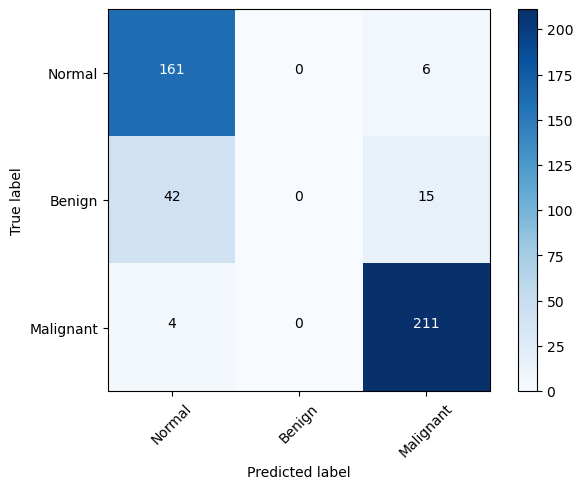

In [14]:
# Make predictions on the test set
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Normal', 'Benign', 'Malignant']
plot_confusion_matrix(cm, classes=class_names)

plt.show()

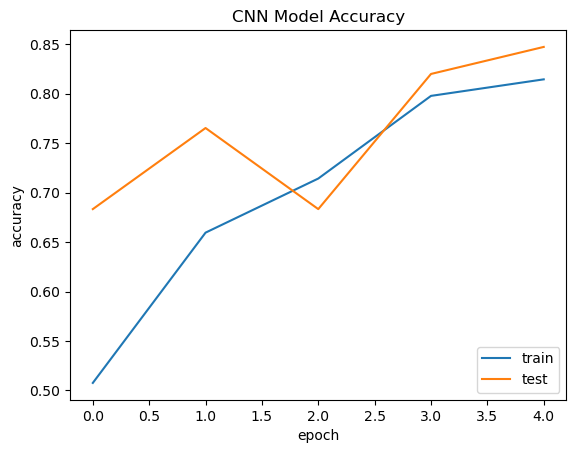

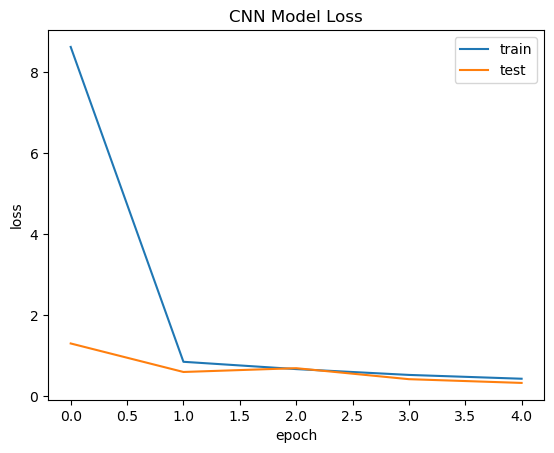

In [15]:
# Learning Curves
plt.plot(history1.history["accuracy"])
plt.plot(history1.history["val_accuracy"])
plt.title("CNN Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")
plt.show()

plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("CNN Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

## Model 2

In [16]:
model2 = keras.Sequential([
    
    # Add hidden layers
    keras.layers.Conv2D(32, 3, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    
    # Add a flatten layer to enable transition from the conv layer
    keras.layers.Flatten(),
    
    # Add a fully connected layer
    keras.layers.Dense(128, activation='relu'),
    
    # Add dropout layer to prevent over-fitting
    keras.layers.Dropout(0.5),
    
    # Add an output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
21/21 [==============================] - 31s 1s/step - loss: 4.6740 - accuracy: 0.5243 - val_loss: 0.6042 - val_accuracy: 0.7563
Epoch 2/5
21/21 [==============================] - 29s 1s/step - loss: 0.4612 - accuracy: 0.8252 - val_loss: 0.3023 - val_accuracy: 0.8724
Epoch 3/5
21/21 [==============================] - 29s 1s/step - loss: 0.2543 - accuracy: 0.9179 - val_loss: 0.1765 - val_accuracy: 0.9271
Epoch 4/5
21/21 [==============================] - 29s 1s/step - loss: 0.1654 - accuracy: 0.9347 - val_loss: 0.1012 - val_accuracy: 0.9727
Epoch 5/5
21/21 [==============================] - 30s 1s/step - loss: 0.1303 - accuracy: 0.9498 - val_loss: 0.0841 - val_accuracy: 0.9727


In [17]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

14/14 [==============================] - 3s 229ms/step - loss: 0.0841 - accuracy: 0.9727
Loss: 0.08
Accuracy: 0.97


14/14 [==============================] - 3s 225ms/step


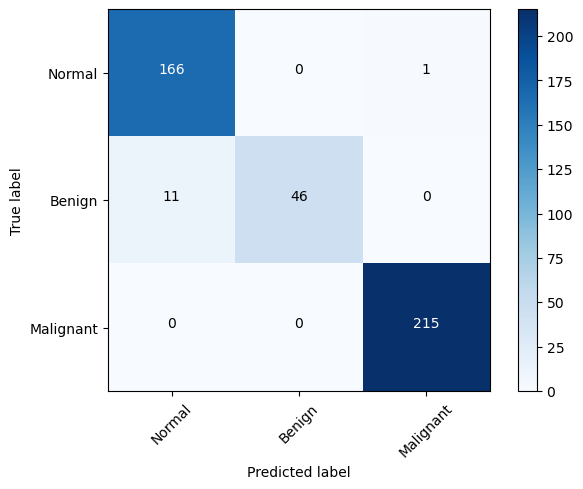

In [18]:
# Make predictions on the test set
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Normal', 'Benign', 'Malignant']
plot_confusion_matrix(cm, classes=class_names)

plt.show()

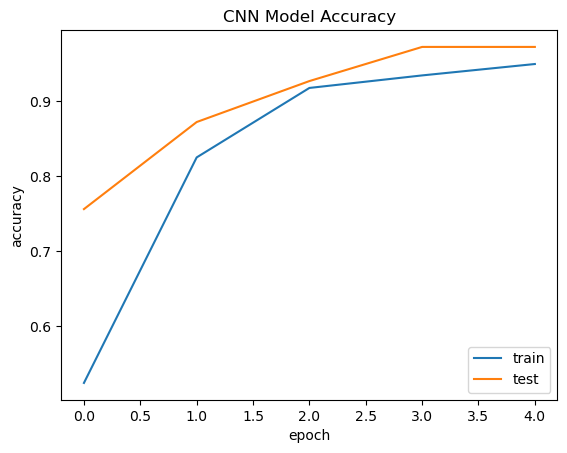

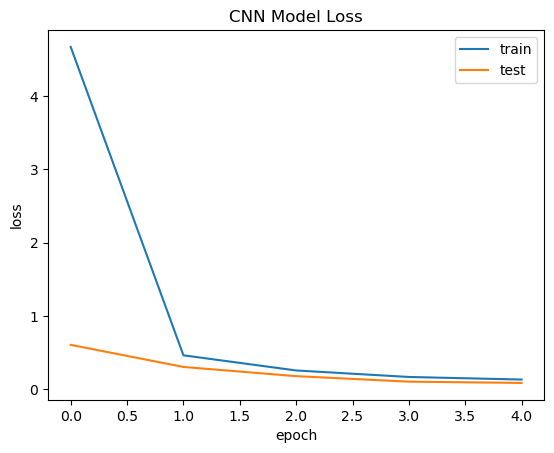

In [19]:
# Learning Curves
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.title("CNN Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")
plt.show()

plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("CNN Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

## Model 3

In [20]:
model3 = keras.Sequential([
    
    # Add hidden layers
    keras.layers.Conv2D(64, 3, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    
    # Add a flatten layer to enable transition from the conv layer
    keras.layers.Flatten(),
    
    # Add a fully connected layer
    keras.layers.Dense(128, activation='relu'),
    
    # Add dropout layer to prevent over-fitting
    keras.layers.Dropout(0.5),
    
    # Add an output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model3.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Train the model
history3 = model3.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
21/21 [==============================] - 57s 3s/step - loss: 10.0193 - accuracy: 0.5289 - val_loss: 0.8253 - val_accuracy: 0.5194
Epoch 2/5
21/21 [==============================] - 57s 3s/step - loss: 0.6715 - accuracy: 0.7173 - val_loss: 0.4721 - val_accuracy: 0.8223
Epoch 3/5
21/21 [==============================] - 56s 3s/step - loss: 0.3804 - accuracy: 0.8495 - val_loss: 0.3943 - val_accuracy: 0.8497
Epoch 4/5
21/21 [==============================] - 56s 3s/step - loss: 0.3035 - accuracy: 0.8784 - val_loss: 0.2096 - val_accuracy: 0.9294
Epoch 5/5
21/21 [==============================] - 56s 3s/step - loss: 0.1946 - accuracy: 0.9134 - val_loss: 0.1918 - val_accuracy: 0.9043


In [21]:
# Evaluate the model
loss, accuracy = model3.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

14/14 [==============================] - 6s 398ms/step - loss: 0.1918 - accuracy: 0.9043
Loss: 0.19
Accuracy: 0.90


14/14 [==============================] - 6s 392ms/step


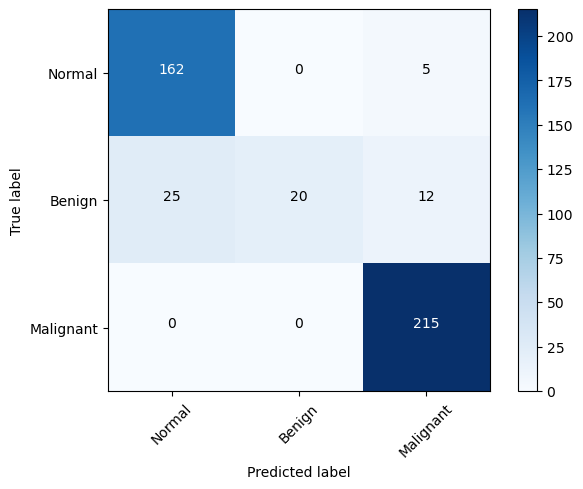

In [22]:
# Make predictions on the test set
y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Normal', 'Benign', 'Malignant']
plot_confusion_matrix(cm, classes=class_names)

plt.show()

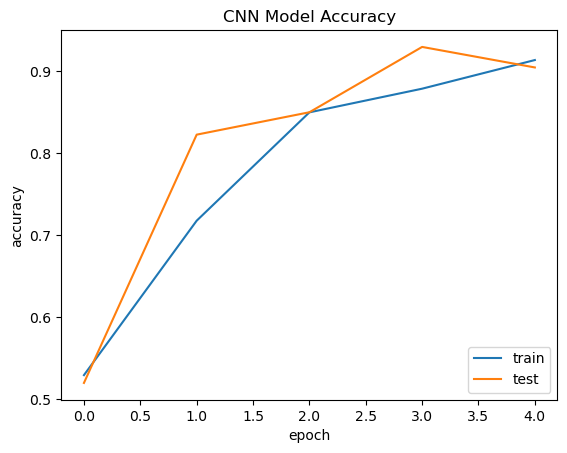

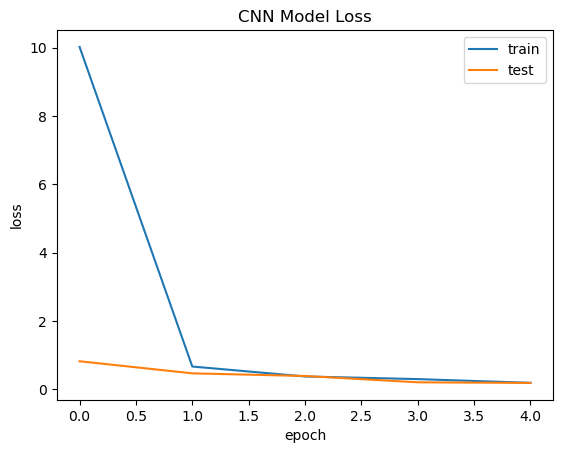

In [23]:
# Learning Curves
plt.plot(history3.history["accuracy"])
plt.plot(history3.history["val_accuracy"])
plt.title("CNN Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")
plt.show()

plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("CNN Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

## Model 4

In [24]:
model4 = keras.Sequential([
    
    # Add hidden layers
    keras.layers.Conv2D(128, 3, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    
    # Add a flatten layer to enable transition from the conv layer
    keras.layers.Flatten(),
    
    # Add a fully connected layer
    keras.layers.Dense(128, activation='relu'),
    
    # Add dropout layer to prevent over-fitting
    keras.layers.Dropout(0.5),
    
    # Add an output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model4.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Train the model
history4 = model4.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
21/21 [==============================] - 127s 6s/step - loss: 12.1736 - accuracy: 0.5729 - val_loss: 0.4481 - val_accuracy: 0.8565
Epoch 2/5
21/21 [==============================] - 115s 6s/step - loss: 0.3613 - accuracy: 0.8799 - val_loss: 0.2947 - val_accuracy: 0.8610
Epoch 3/5
21/21 [==============================] - 126s 6s/step - loss: 0.1557 - accuracy: 0.9498 - val_loss: 0.0826 - val_accuracy: 0.9749
Epoch 4/5
21/21 [==============================] - 116s 6s/step - loss: 0.1046 - accuracy: 0.9696 - val_loss: 0.0481 - val_accuracy: 0.9909
Epoch 5/5
21/21 [==============================] - 115s 5s/step - loss: 0.0773 - accuracy: 0.9726 - val_loss: 0.0448 - val_accuracy: 0.9909


In [25]:
# Evaluate the model
loss, accuracy = model4.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

14/14 [==============================] - 10s 701ms/step - loss: 0.0448 - accuracy: 0.9909
Loss: 0.04
Accuracy: 0.99


14/14 [==============================] - 10s 709ms/step


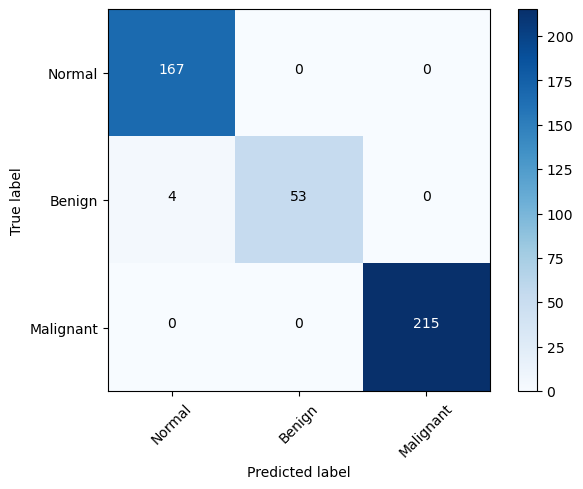

In [26]:
# Make predictions on the test set
y_pred = model4.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Normal', 'Benign', 'Malignant']
plot_confusion_matrix(cm, classes=class_names)

plt.show()

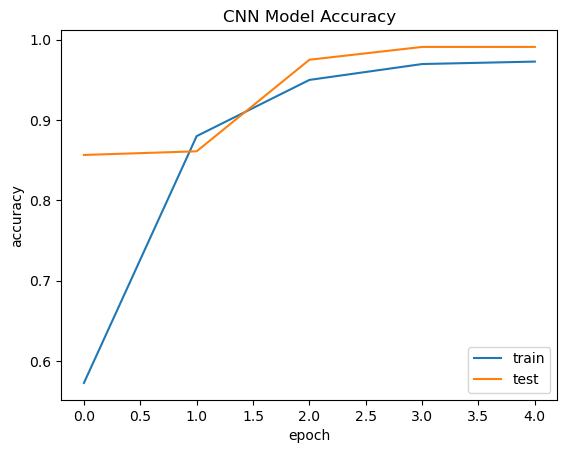

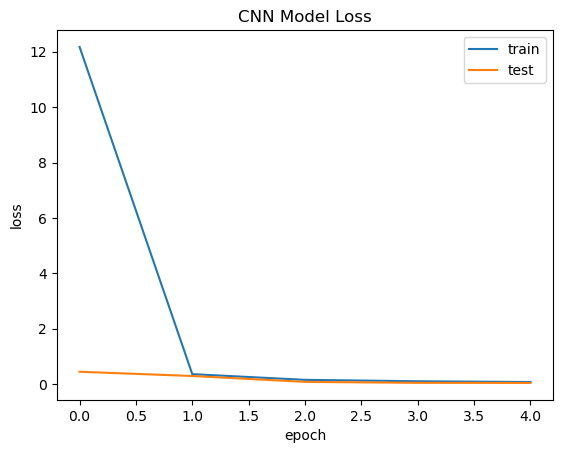

In [27]:
# Learning Curves
plt.plot(history4.history["accuracy"])
plt.plot(history4.history["val_accuracy"])
plt.title("CNN Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")
plt.show()

plt.plot(history4.history["loss"])
plt.plot(history4.history["val_loss"])
plt.title("CNN Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

## Hyperparameter Tuning

In [28]:
def build_model(hp):
    
    model = keras.Sequential()
     
    for i in range(hp.Int("Conv layer", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16, 32, 64,128]), 3, input_shape=(224, 224, 1), activation='relu'))
    
    model.add(keras.layers.MaxPool2D(2, 2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))
    
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials=5,
    directory='./new_directory'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Trial 5 Complete [00h 15m 58s]
val_accuracy: 0.9908883571624756

Best val_accuracy So Far: 0.9931662678718567
Total elapsed time: 00h 47m 43s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_model = tuner.get_best_models()[0]

In [30]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

14/14 [==============================] - 5s 358ms/step - loss: 0.0938 - accuracy: 0.9932


[0.09376842528581619, 0.9931662678718567]

In [31]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 flatten (Flatten)           (None, 193600)            0         
                                                                 
 dense (Dense)               (None, 512)               99123712  
                                                        

In [32]:
tuner.results_summary()

Results summary
Results in ./new_directory\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
Conv layer: 2
Dense layer: 512
layer_0_filters: 16
layer_1_filters: 16
Score: 0.9931662678718567

Trial 3 summary
Hyperparameters:
Conv layer: 2
Dense layer: 64
layer_0_filters: 64
layer_1_filters: 16
Score: 0.9931662678718567

Trial 4 summary
Hyperparameters:
Conv layer: 1
Dense layer: 512
layer_0_filters: 32
layer_1_filters: 16
Score: 0.9908883571624756

Trial 0 summary
Hyperparameters:
Conv layer: 0
Dense layer: 256
Traceback (most recent call last):
  File "C:\Users\badullah\AppData\Local\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\badullah\AppData\Local\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial

In [38]:
model = keras.Sequential([
    
    # Add hidden layers
    keras.layers.Conv2D(16, 3, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.5),
    
    # Add a flatten layer to enable transition from the conv layer
    keras.layers.Flatten(),
        
    # Add a fully connected layer
    keras.layers.Dense(512, activation='relu'),
    
    # Add dropout layer to prevent over-fitting
    keras.layers.Dropout(0.5),
        
    # Add an output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
21/21 [==============================] - 62s 3s/step - loss: 3.6790 - accuracy: 0.5821 - val_loss: 0.5989 - val_accuracy: 0.8155
Epoch 2/5
21/21 [==============================] - 63s 3s/step - loss: 0.2814 - accuracy: 0.9134 - val_loss: 0.2057 - val_accuracy: 0.9180
Epoch 3/5
21/21 [==============================] - 67s 3s/step - loss: 0.0635 - accuracy: 0.9848 - val_loss: 0.0531 - val_accuracy: 0.9818
Epoch 4/5
21/21 [==============================] - 68s 3s/step - loss: 0.0215 - accuracy: 0.9924 - val_loss: 0.0237 - val_accuracy: 0.9932
Epoch 5/5
21/21 [==============================] - 74s 4s/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.0391 - val_accuracy: 0.9909


In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

14/14 [==============================] - 6s 405ms/step - loss: 0.0275 - accuracy: 0.9886
Loss: 0.03
Accuracy: 0.99


14/14 [==============================] - 5s 351ms/step


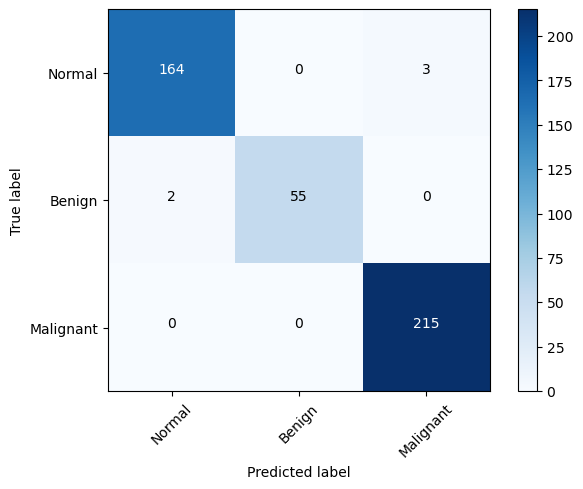

In [35]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Normal', 'Benign', 'Malignant']
plot_confusion_matrix(cm, classes=class_names)

plt.show()

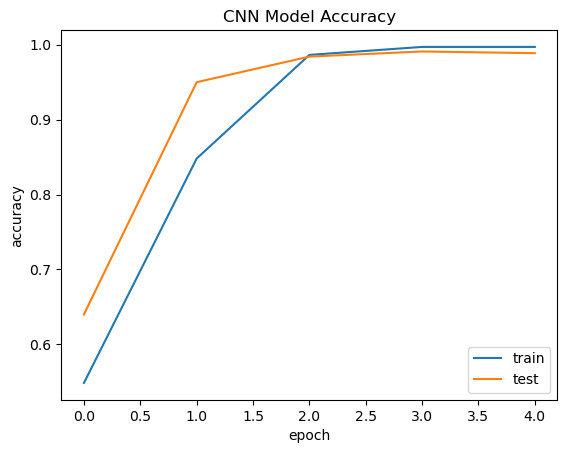

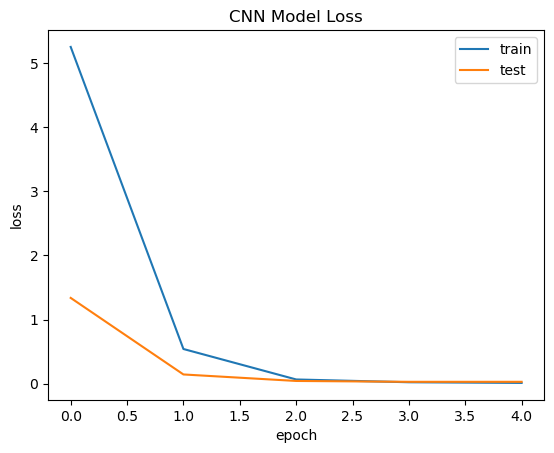

In [36]:
# Learning Curves
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("CNN Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("CNN Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()